Code necessary to generate Figure2C

In [1]:
### imports 
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn import svm, metrics
import glob
import os
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy import stats
import matplotlib.patches as mpatches


In [2]:
### functions
def makefolder(path):
    """Creates folder if it does not exist"""
    if not os.path.exists(path):
        os.makedirs(path)

def runSVM_onetimepoint(frvalues, labels):
    """Run SVM"""
    X = frvalues
    y = labels
    skf1 = StratifiedKFold(n_splits=5, shuffle=True)
    svc = svm.SVC(kernel='linear')

    ypred = np.zeros(y.shape)

    for trainidx, testidx in skf1.split(X, y):
        scaler = StandardScaler()
        Xtrain, Xtest = X[trainidx], X[testidx]
        ytrain, ytest = y[trainidx], y[testidx]

        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        svc.fit(Xtrain, ytrain)
        ypred[testidx] = svc.predict(Xtest)

    accuracy = metrics.accuracy_score(y, ypred)
    return accuracy

def calculateallneuronmatrix(folderpath, neuronlist):
    """format data to allow for selection of balanced dataset"""
    frmatrix_rewarded = np.full((100, 40, len(neuronlist)), np.nan)
    frmatrix_unrewarded = np.full((100, 40, len(neuronlist)), np.nan)
    labelmatrix_rewarded = np.full((200, neuronlist.shape[0]), np.nan)
    labelmatrix_unrewarded = np.full((200, neuronlist.shape[0]), np.nan)

    for n in range(len(neuronlist)):
        neuron = neuronlist[n]
        rat, date, area, unitid = neuron[0], neuron[1], neuron[2], neuron[3]
        pathname = rat + '_' + date + '_*_' + unitid

        rewardpath = glob.glob(folderpath + pathname + '_rewarded.npy')[0]
        unrewardpath = glob.glob(folderpath + pathname + '_unrewarded.npy')[0]

        reward = np.load(rewardpath)
        unreward = np.load(unrewardpath)

        frmatrix_rewarded[:reward.shape[0], :, n] = reward
        frmatrix_unrewarded[:unreward.shape[0], :, n] = unreward

        labelmatrix_rewarded[:reward.shape[0], n] = np.ones(reward.shape[0])
        labelmatrix_unrewarded[:unreward.shape[0], n] = np.zeros(unreward.shape[0])

    return frmatrix_rewarded, frmatrix_unrewarded, labelmatrix_rewarded, labelmatrix_unrewarded

In [3]:
# ---- Run SVM decoding on prelearning and postlearning data for the LA, BLA and PIR ----

# ---- Parameters ----
cwd = os.getcwd()  # current working directory

masterlistpath = os.path.join(cwd, 'masterlist_experiment1task.csv')
masterlist = np.loadtxt(masterlistpath, delimiter=',', dtype=str)

folderpath = os.path.join(cwd, 'data_timewarped')
folderpath_prelearning = os.path.join(folderpath, 'prelearning/')
folderpath_postlearning = os.path.join(folderpath, 'postlearning/')

savepath = os.path.join(cwd, 'Figure2C/')
makefolder(savepath)
savename = 'experiment1'

areas = [['LA'], ['BLA'], ['PIR']]
restrictneuronnum = 50
iterationstorun = 100

# saved information. d1=areas, d2=timewarp timepoints, d3=iteration, d4=pre/post learning
saveaccuracy = np.zeros((len(areas), 40, iterationstorun, 2))
saveaccuracyshuffle = np.zeros((len(areas), 40, iterationstorun, 2))

parameters = [
    ['iterationstorun', iterationstorun], 
    ['restrictneuronnum', restrictneuronnum],
    ['masterlistpath', masterlistpath], 
    ['folderpath', folderpath]
]

# ---- Main Loop ----
for a, area in enumerate(areas):
    print(area)
    neuronstouse = masterlist[np.isin(masterlist[:, 2], area)]
    print('Number of Neurons = ' + str(neuronstouse.shape[0]))

    # create matrices
    prefrmatrix_rewarded, prefrmatrix_unrewarded, prelabelmatrix_rewarded, prelabelmatrix_unrewarded = calculateallneuronmatrix(
        folderpath_prelearning, neuronstouse)
    postfrmatrix_rewarded, postfrmatrix_unrewarded, postlabelmatrix_rewarded, postlabelmatrix_unrewarded = calculateallneuronmatrix(
        folderpath_postlearning, neuronstouse)

    # balanced dataset
    prerewardedcountperneuron = np.count_nonzero(prelabelmatrix_rewarded == 1, axis=0)
    preunrewardedcountperneuron = np.count_nonzero(prelabelmatrix_unrewarded == 0, axis=0)
    postrewardedcountperneuron = np.count_nonzero(postlabelmatrix_rewarded == 1, axis=0)
    postunrewardedcountperneuron = np.count_nonzero(postlabelmatrix_unrewarded == 0, axis=0)

    mininstance = np.min(
        [np.min(prerewardedcountperneuron), np.min(preunrewardedcountperneuron), 
         np.min(postrewardedcountperneuron), np.min(postunrewardedcountperneuron)])
    print('minimum trial count task = ' + str(mininstance))

    for x in range(iterationstorun):
        #select a new group of neurons per iteration
        if restrictneuronnum == 'nan':
            neuronidx = np.arange(neuronstouse.shape[0])
        else:
            neuronidx = np.random.choice(neuronstouse.shape[0], restrictneuronnum, replace=False)

        for n, nn in enumerate(neuronidx):
            preselectrewarded = np.random.choice(prerewardedcountperneuron[nn], mininstance, replace=False)
            preselectunrewarded = np.random.choice(preunrewardedcountperneuron[nn], mininstance, replace=False)
            postselectrewarded = np.random.choice(postrewardedcountperneuron[nn], mininstance, replace=False)
            postselectunrewarded = np.random.choice(postunrewardedcountperneuron[nn], mininstance, replace=False)

            if n == 0:
                prefrvalues = np.vstack((prefrmatrix_rewarded[preselectrewarded, :, nn], prefrmatrix_unrewarded[preselectunrewarded, :, nn]))
                postfrvalues = np.vstack((postfrmatrix_rewarded[postselectrewarded, :, nn], postfrmatrix_unrewarded[postselectunrewarded, :, nn]))
            else:
                prefrvalues = np.dstack((prefrvalues, np.vstack((prefrmatrix_rewarded[preselectrewarded, :, nn], prefrmatrix_unrewarded[preselectunrewarded, :, nn]))))
                postfrvalues = np.dstack((postfrvalues, np.vstack((postfrmatrix_rewarded[postselectrewarded, :, nn], postfrmatrix_unrewarded[postselectunrewarded, :, nn]))))

        tasklabels = np.append(np.ones(mininstance), np.zeros(mininstance))
        shuffledlabels = np.copy(tasklabels)
        np.random.shuffle(shuffledlabels)

        for t in range(40):
            saveaccuracy[a, t, x, 0] = runSVM_onetimepoint(prefrvalues[:, t, :], tasklabels)
            saveaccuracyshuffle[a, t, x, 0] = runSVM_onetimepoint(prefrvalues[:, t, :], shuffledlabels)
            saveaccuracy[a, t, x, 1] = runSVM_onetimepoint(postfrvalues[:, t, :], tasklabels)
            saveaccuracyshuffle[a, t, x, 1] = runSVM_onetimepoint(postfrvalues[:, t, :], shuffledlabels)

        print('iteration ' + str(x) + ' done for area ' + str(area))

# ---- Save results ----
np.save(os.path.join(savepath, savename + '_accuracy.npy'), saveaccuracy)
np.save(os.path.join(savepath, savename + '_accuracyshuffle.npy'), saveaccuracyshuffle)

['LA']
Number of Neurons = 380
minimum trial count task = 9
iteration 0 done for area ['LA']
iteration 1 done for area ['LA']
iteration 2 done for area ['LA']
iteration 3 done for area ['LA']
iteration 4 done for area ['LA']
iteration 5 done for area ['LA']
iteration 6 done for area ['LA']
iteration 7 done for area ['LA']
iteration 8 done for area ['LA']
iteration 9 done for area ['LA']
iteration 10 done for area ['LA']
iteration 11 done for area ['LA']
iteration 12 done for area ['LA']
iteration 13 done for area ['LA']
iteration 14 done for area ['LA']
iteration 15 done for area ['LA']
iteration 16 done for area ['LA']
iteration 17 done for area ['LA']
iteration 18 done for area ['LA']
iteration 19 done for area ['LA']
iteration 20 done for area ['LA']
iteration 21 done for area ['LA']
iteration 22 done for area ['LA']
iteration 23 done for area ['LA']
iteration 24 done for area ['LA']
iteration 25 done for area ['LA']
iteration 26 done for area ['LA']
iteration 27 done for area ['LA'

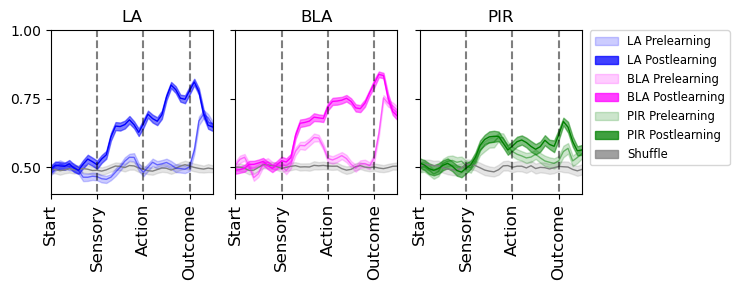

<Figure size 640x480 with 0 Axes>

In [4]:
### Plot figure

# ---- Parameters ----
cwd = os.getcwd()
savename = 'experiment1'   # same as in previous cell
folderpath = os.path.join(cwd, 'Figure2C/')

decoding = np.load(os.path.join(folderpath, savename + '_accuracy.npy'))
shuffle = np.load(os.path.join(folderpath, savename + '_accuracyshuffle.npy'))

areas = ['LA', 'BLA', 'PIR']
areavalues = [0, 1, 2]
colors = ['blue', 'magenta', 'green']

plt.close()

fig, ax = plt.subplots(1, len(areas), figsize=(2.5*len(areas), 3), sharey='row', sharex='all')

for a, area in enumerate(areas):
    areaidx = areavalues[a]
    prelearning_mean = gaussian_filter1d(np.mean(decoding[areaidx, :, :, 0], axis=1), .75)
    postlearning_mean = gaussian_filter1d(np.mean(decoding[areaidx, :, :, 1], axis=1), .75)
    shuffle_mean1 = gaussian_filter1d(np.mean(shuffle[areaidx, :, :, 0], axis=1), .75)
    shuffle_mean2 = gaussian_filter1d(np.mean(shuffle[areaidx, :, :, 1], axis=1), .75)
    shuffle_mean = np.mean(np.vstack((shuffle_mean1, shuffle_mean2)), axis=0)

    prelearning_sem = stats.sem(decoding[areaidx, :, :, 0], axis=1)
    postlearning_sem = stats.sem(decoding[areaidx, :, :, 1], axis=1)
    shuffle_sem1 = stats.sem(shuffle[areaidx, :, :, 0], axis=1)
    shuffle_sem2 = stats.sem(shuffle[areaidx, :, :, 1], axis=1)
    shuffle_sem = np.mean(np.vstack((shuffle_sem1, shuffle_sem2)), axis=0)

    ax[a].plot(shuffle_mean, lw=1, color='gray')
    ax[a].fill_between(np.arange(40), shuffle_mean-shuffle_sem, shuffle_mean+shuffle_sem, color='gray', alpha=0.2)

    ax[a].plot(prelearning_mean, lw=1, color=colors[a], alpha=0.5)
    ax[a].fill_between(np.arange(40), prelearning_mean-prelearning_sem, prelearning_mean+prelearning_sem, color=colors[a], alpha=0.2)

    ax[a].plot(postlearning_mean, lw=1, color=colors[a])
    ax[a].fill_between(np.arange(40), postlearning_mean-postlearning_sem, postlearning_mean+postlearning_sem, color=colors[a], alpha=0.5)

    ax[a].vlines((10, 20, 30), 0, 1, color='k', linestyle='--', alpha=0.5)
    ax[a].set_ylim(0.4, 1)

    ax[a].set_xticks((0, 10, 20, 30, 40))
    ax[a].set_xticklabels(('Start', 'Sensory', 'Action', 'Outcome', 'End'), fontsize=12, rotation=90)
    ax[a].set_title(area)

# ---- Legend ----
legend_colors = ['blue', 'blue', 'magenta', 'magenta', 'green', 'green', 'gray']
legend_labels = ['LA Prelearning', 'LA Postlearning', 'BLA Prelearning', 'BLA Postlearning', 'PIR Prelearning', 'PIR Postlearning', 'Shuffle']
legend_alpha = [0.2, 0.75, 0.2, 0.75, 0.2, 0.75, 0.75]

legend_patches = [mpatches.Patch(color=color, alpha=a, label=label) for color, label, a in zip(legend_colors, legend_labels, legend_alpha)]
ax[2].legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize='small')

ax[0].set_yticks((0.5, 0.75, 1.0))
ax[0].set_xlim(0, 35)
plt.tight_layout()

# ---- Show inline ----
plt.show()

# ---- Save figures ----
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig(os.path.join(folderpath, savename + '_decoding.svg'), format='svg')
plt.savefig(os.path.join(folderpath, savename + '_decoding.png'), format='png')
